In [6]:
# 랜덤 초기화
import numpy as np
np.random.seed(98643)
import tensorflow as tf
tf.random.set_seed(683)

# An image clearing dependencies
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                denoise_wavelet, estimate_sigma, denoise_tv_bregman,
                                denoise_nl_means)
from skimage.filters import gaussian
from skimage.color import rgb2gray

# data reading and visualization
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

# training part
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, GlobalAveragePooling2D, Lambda
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator

* 데이터 전처리 필요
> 제공된 이미지의 세분화된 노이즈를 제거하면 더 잘 예측할 수 있음

모델 학습에 더 많이 사용할 수있는 일부 전역 기능을 추출하기 위해 데이터 세트에서 노이즈 제거 자동 인코더를 학습시키는 것도 흥미 롭습니다.

It is also interesting to train a denoising autoencoder on dataset in order to extract some global features that may be used further on model training.

In [16]:
# 이미지 포맷으로 데이터 translate
def color_composite(data):
    rgb_arrays = []
    for i, row in data.iterrows():
        band_1 = np.array(row['band_1']).reshape(75,75)
        band_2 = np.array(row['band_2']).reshape(75,75)
        band_3 = band_1 / band_2
        
        r = (band_1 + abs(band_1.min())) / np.max((band_1 + abs(band_1.min())))
        g = (band_2 + abs(band_2.min())) / np.max((band_2 + abs(band_2.min())))
        b = (band_3 + abs(band_3.min())) / np.max((band_3 + abs(band_3.min())))
        
        rgb = np.dstack((r, g, b))
        rgb_arrays.append(rgb)
    return np.array(rgb_arrays)

def denoise(X, weight, multichannel):
    return np.asarray([denoise_tv_chambolle(item, weight = weight, multichannel = multichannel) for item in X])

def smooth(X, sigma):
    return np.asarray([gaussian(item, sigma = sigma) for item in X])

def grayscale(X):
    return np.asarray([rgb2gray(item) for item in X])

## 이미지 복원 모듈
|모듈|설명|
|--|--|
|skimage.restoration.calibrate_denoiser(…)|노이즈 제거 기능을 보정하고 최적의 J- 불변 버전을 반환|
|skimage.restoration.cycle_spin(x, func,…)|순환 회전 (x의 이동 된 버전에 func를 반복적으로 적용)|
|skimage.restoration.denoise_bilateral(image)|양측 필터를 사용하여 이미지 노이즈 제거|
|skimage.restoration.denoise_nl_means(image)|2D 또는 3D 그레이 스케일 이미지와 2D RGB 이미지에서 비 로컬 평균 노이즈 제거|
|skimage.restoration.denoise_tv_bregman(…)|split-Bregman 최적화를 사용하여 전체 변동 노이즈 제거|
|skimage.restoration.denoise_tv_chambolle(image)|n 차원 이미지에서 전체 변형 노이즈 제거|
|skimage.restoration.denoise_wavelet(image[, …])|이미지에 웨이블릿 노이즈 제거|
|skimage.restoration.estimate_sigma(image[, …])|(가우시안) 잡음 표준 편차의 강력한 웨이블릿 기반 추정량|
|skimage.restoration.inpaint_biharmonic(…)|바이 하모닉 방정식을 사용하여 이미지의 마스크 된 포인트를 페인트|
|skimage.restoration.richardson_lucy(image, psf)|Richardson-Lucy 디컨볼루션|
|skimage.restoration.unsupervised_wiener(…)|감독되지 않은 Wiener-Hunt 디컨볼루션|
|skimage.restoration.unwrap_phase(image[, …])|래핑된 위상 이미지에서 원본을 복구|
|skimage.restoration.wiener(image, psf, balance)|Wiener-Hunt 디컨볼루션|

denoise()
* weight: Denoising weight. The greater weight, the more denoising
* multichannel : 각 채널에 대해 개별적으로 전체 변형 노이즈 제거를 적용합니다. 이 옵션은 컬러 이미지에 대해 true 여야합니다. 그렇지 않으면 노이즈 제거가 채널 차원에도 적용됩니다.

https://scikit-image.org/docs/stable/api/skimage.restoration.html

### skimage.filters.gaussian(image[, sigma, …])
- 이미지를 다차원 가우시안 필터로 필터링

https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.gaussian

## Rgb to grayscale
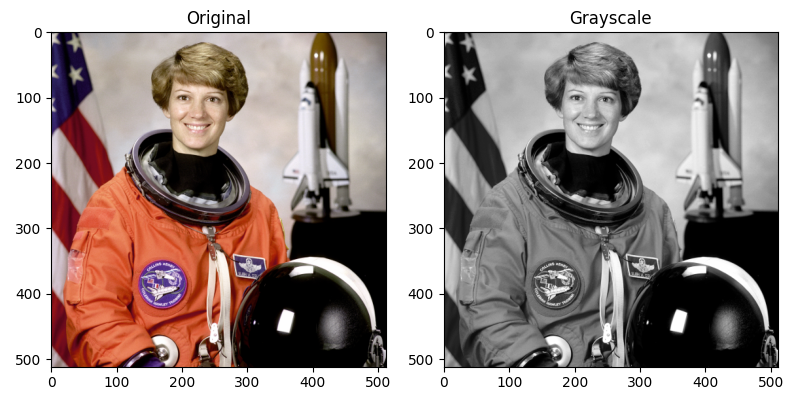

## dstack
dstack 명령은 제3의 축 즉, 행이나 열이 아닌 깊이(depth) 방향으로 배열을 합친다. 가장 안쪽의 원소의 차원이 증가한다. 즉 가장 내부의 숫자 원소가 배열이 된다. shape 정보로 보자면 가장 끝에 값이 2인 차원이 추가되는 것이다.이 예제의 경우에는 shape 변화가 2개의 (3 x 4) -> 1개의 (3 x 4 x 2)가 된다.

In [40]:
# dstack 예시

c1 = np.ones((3, 4, 2))
print(c1)
c2 = np.zeros((3, 4, 2))
print(c2)
print(np.dstack([c1, c2]))
np.dstack([c1, c2]).shape

[[[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]]
[[[0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]]]
[[[1. 1. 0. 0.]
  [1. 1. 0. 0.]
  [1. 1. 0. 0.]
  [1. 1. 0. 0.]]

 [[1. 1. 0. 0.]
  [1. 1. 0. 0.]
  [1. 1. 0. 0.]
  [1. 1. 0. 0.]]

 [[1. 1. 0. 0.]
  [1. 1. 0. 0.]
  [1. 1. 0. 0.]
  [1. 1. 0. 0.]]]


(3, 4, 4)

In [8]:
train = pd.read_json('input/train.json/data/processed/train.json')
train.inc_angle = train.inc_angle.replace('na', 0)
train.inc_angle = train.inc_angle.astype(float).fillna(0.0)
train_all = True

# 모델을보다 효율적으로 학습하고 적절한 모델 매개 변수를 선택하는 데 필요한 학습 플래그
train_b = True or train_all
train_img = True or train_all
train_total = True or train_all
predict_submission = True or train_all

clean_all = False
clean_b = False or clean_all
clean_img = False or clean_all

load_all = False
load_b = False or load_all
load_img = False or load_all

In [10]:
train.head()

,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


* id: 이미지의 id
* band_1, band_2: 병합된 이미지 데이터. 각 밴드에는 75X75 픽셀 값이 리스트에 저장되어 있으므로 한 행 당 총 5625개의 elements들 존재. 이 값은 물리적인 의미가 있기 때문에 음이 아닌 일반 정수가 아님. band_1과 band_2는 특정 입사각에서 서로 다른 편광에서 생성된 레이더 backscatter이 특징인 신호. 편광은 HH(수평 전송/수신) 및 HB(수평 전송 및 수직 수신)에 해당. 
* inc_angle: 이미지가 촬영된 입사각. na값 존재
* is_iceberg: 대상 변수, 빙산이면 1로 설정하고 배이면 0으로 설정

In [23]:
def create_dataset(frame, labeled, smooth_rgb = 0.2, smooth_gray = 0.5,
                  weight_rgb = 0.05, weight_gray = 0.05):
    band_1, band_2, images = frame['band_1'].values, frame['band_2'].values, color_composite(frame)
    to_arr = lambda x: np.asarray([np.asarray(item) for item in x])
    # 배열 형태로 인식하도록
    band_1 = to_arr(band_1)
    band_2 = to_arr(band_2)
    band_3 = (band_1 + band_2) / 2
    # 75*75 배열 모양으로
    gray_reshape = lambda x: np.asarray([item.reshape(75,75) for item in x])
    
    # flat 벡터에서 picture 포맷으로 만들기
    band_1 = gray_reshape(band_1)
    band_2 = gray_reshape(band_2)
    band_3 = gray_reshape(band_3)
    print('Denoising and reshaping')
    
    if train_b and clean_b:
        # smooth and denoise data
        band_1 = smooth(denoise(band_1, weight_gray, False), smooth_gray)
        print('Gray 1 done')
        band_2 = smooth(denoise(band_2, weight_gray, False), smooth_gray)
        print('Gray 2 done')
        band_3 = smooth(denoise(band_3, weight_gray, False), smooth_gray)
        print('Gray 3 done')
        
    if train_img and clean_img:
        images = smooth(denoise(images, weight_rgb, True), smooth_rgb)
    print('RGB done')
    
    # 텐서 모양으로 변환
    tf_reshape = lambda x: np.asarray([item.reshape(75,75,1) for item in x])
    band_1 = tf_reshape(band_1)
    band_2 = tf_reshape(band_2)
    band_3 = tf_reshape(band_3)
    #images = tf_reshape(images)
    band = np.concatenate([band_1, band_2, band_3], axis=3)
    if labeled:
        y = np.array(frame['is_iceberg'])
    else:
        y = None
    return y, band, images

In [24]:
y_train, X_b, X_images = create_dataset(train, True)

Denoising and reshaping
RGB done


* X_b: train set의 band1, band2, 그 둘의 평균을 원하는 형태로 변형한 결과 -> (1604, 75, 75, 3)
* X_images: band1, band2, band3를 각각 r,g,b로 인식 후 변환 -> (1604, 75, 75,3)

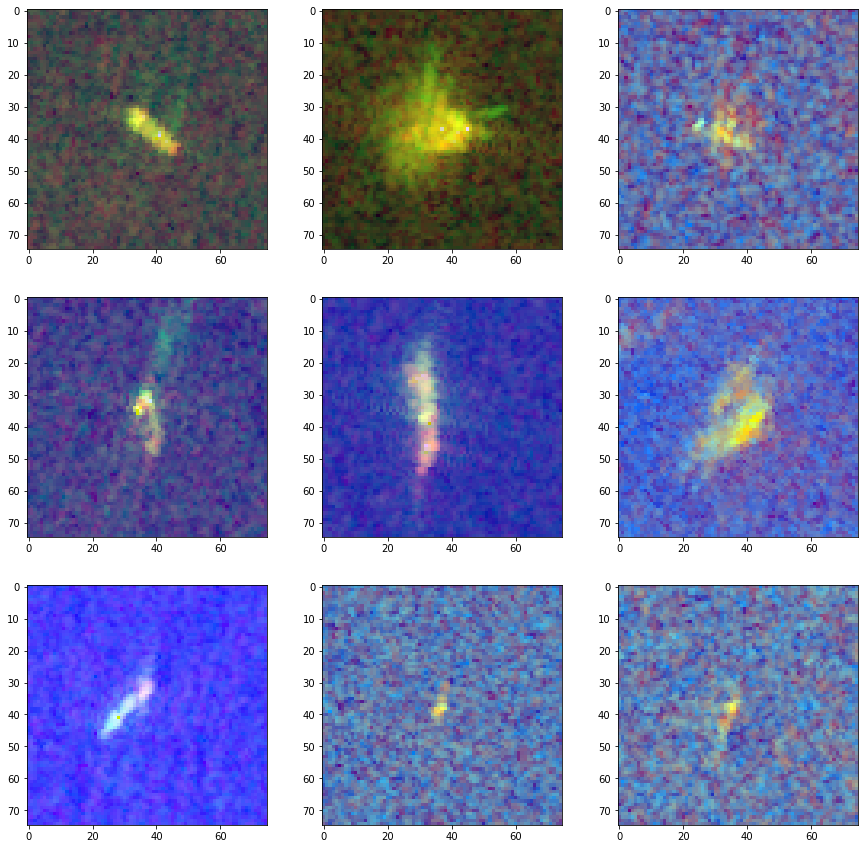

In [25]:
# 노이즈 클렌징 한 사진들
fig = plt.figure(200, figsize = (15,15))
random_indicies = np.random.choice(range(len(X_images)), 9, False)
subset = X_images[random_indicies]
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    ax.imshow(subset[i])
plt.show()

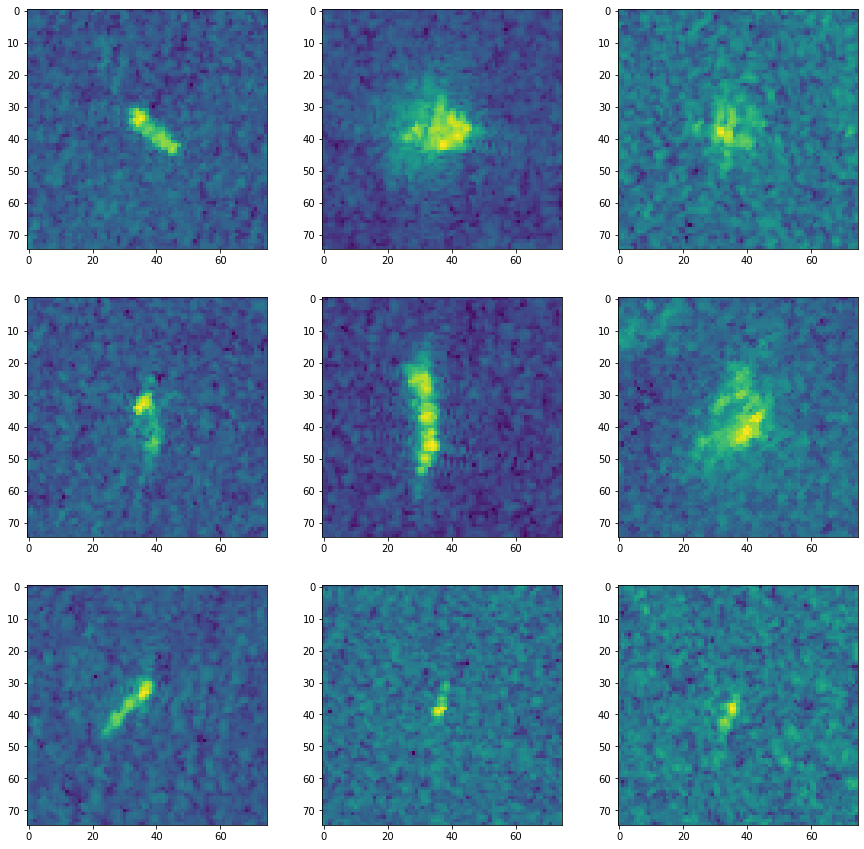

In [26]:
fig = plt.figure(202, figsize = (15,15))
band_1_x = train['band_1'].values
subset = np.asarray(band_1_x)[random_indicies]
subset = np.asarray([np.asarray(item).reshape(75,75) for item in subset])
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    ax.imshow(subset[i])
plt.show()

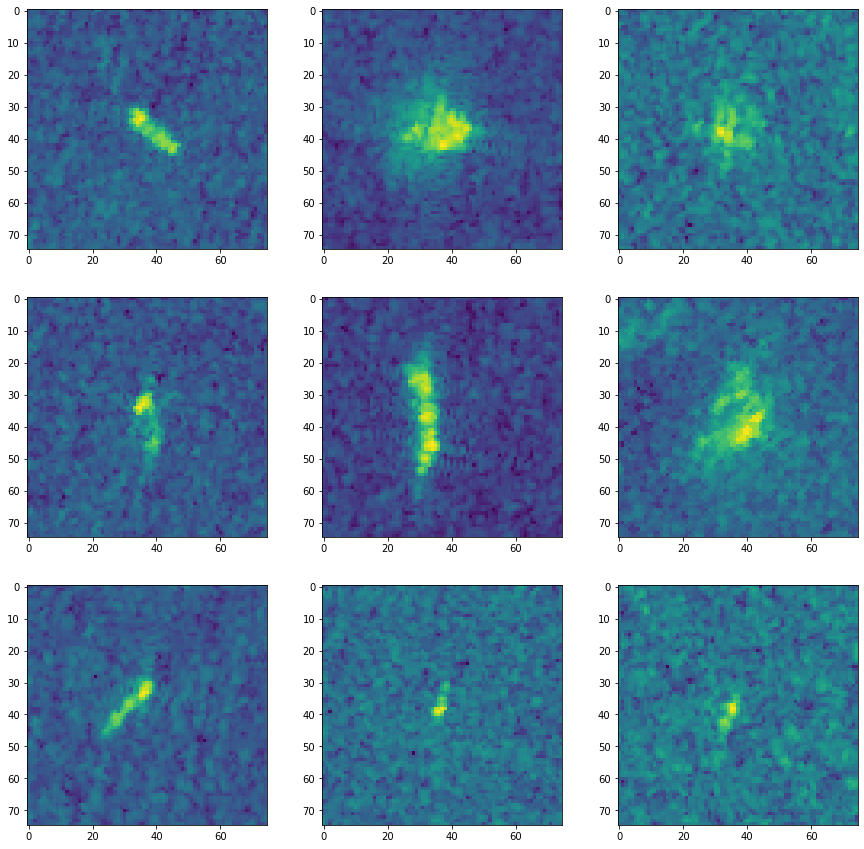

In [27]:
fig = plt.figure(202, figsize = (15,15))
band_1_x = train['band_1'].values
subset = np.asarray(band_1_x)[random_indicies]
# n 차원 이미지에서 전체 변형 노이즈 제거
subset = denoise(np.asarray([np.asarray(item).reshape(75,75) for item in subset]), 0.05, False)
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    ax.imshow(subset[i])
plt.show()

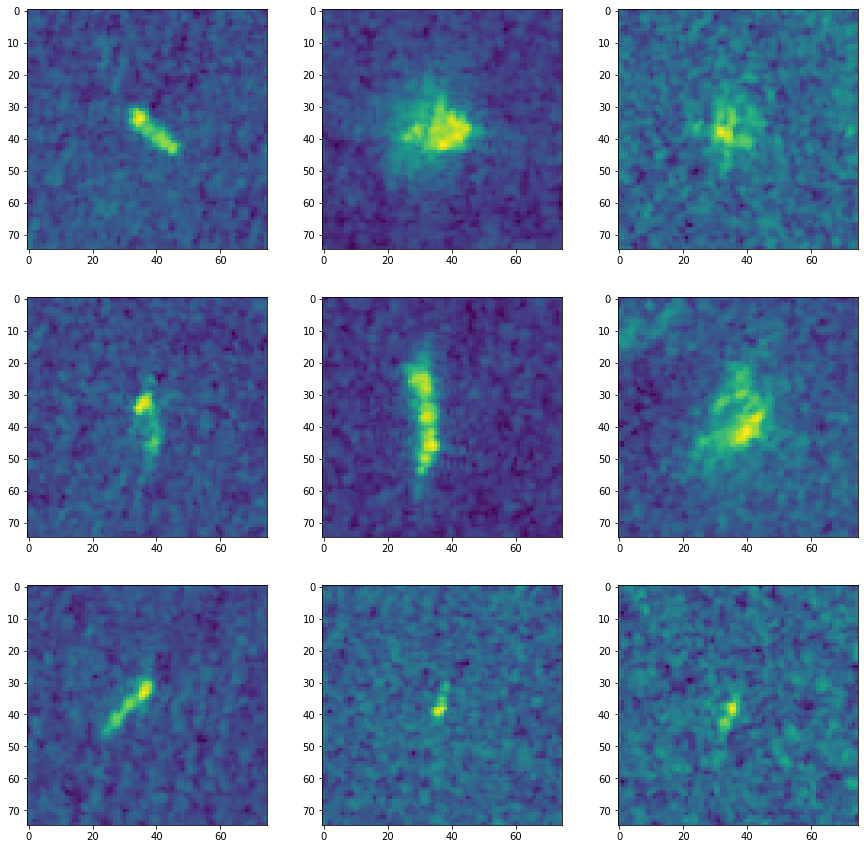

In [28]:
fig = plt.figure(202, figsize=(15, 15))
subset = np.asarray(band_1_x)[random_indicies]
subset = smooth(denoise(np.asarray(
    [np.asarray(item).reshape(75, 75) for item in subset]), 0.05, False), 0.5)
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(subset[i])
plt.show()

## 모델에 대한 몇 마디
모델 자체는 3 개의 컨볼 루션 신경망으로 구성됩니다. 두 개의 기본 네트워크와 하나의 결합. 아이디어는 서로 다른 데이터 표현에 대해 두 개의 기본 네트워크를 훈련시킨 후 훈련된 컨볼루션 레이어를 조합하여 공통 네트워크를 훈련시키는 것입니다.

훈련을 위해 3 개의 데이터 세트를 사용하고 있는데, 1 개는 네트워크가 한 번만 보고 모델 선택을 위해 기본 keras val 분할을 표시합니다.

In [29]:
def get_model_notebook(lr, decay, channels, relu_type = 'relu'):
    # 각도 변수(angle variable)는 각도 매개 변수를 사용해야하는지 아니면 무시해야하는지 정의합니다.
    input_1 = Input(shape = (75, 75, channels))
    
    fcnn = Conv2D(32, kernel_size = (3,3), activation = relu_type)(BatchNormalization()(input_1))
    fcnn = MaxPooling2D((3,3))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    
    fcnn = Conv2D(64, kernel_size = (3,3), activation = relu_type)(fcnn)
    fcnn = MaxPooling2D((2,2), strides = (2,2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    
    fcnn = Conv2D(128, kernel_size = (3, 3), activation = relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides = (2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    
    fcnn = Conv2D(128, kernel_size = (3, 3), activation = relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides = ( 2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    
    fcnn = BatchNormalization()(fcnn)
    fcnn = Flatten()(fcnn)
    
    local_input = input_1
    partial_model = Model(input_1, fcnn)
    dense = Dropout(0.2)(fcnn)
    dense = Dense(256, activation = relu_type)(dense)
    dense = Dropout(0.2)(dense)
    dense = Dense(128, activation = relu_type)(dense)
    dense = Dropout(0.2)(dense)
    dense = Dense(64, activation = relu_type)(dense)
    dense = Dropout(0.2)(dense)
    
    # 어떤 이유로 각도 데이터를 정규화하지 않기로 결정
    output = Dense(1, activation = "sigmoid")(dense)
    model = Model(local_input, output)
    optimizer = Adam(lr = lr, decay = decay)
    model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
    return model, partial_model

In [30]:
def combined_model(m_b, m_img, lr, decay):
    input_b = Input(shape = (75, 75, 3))
    input_img = Input(shape = (75, 75, 3))

    # for layer in m_b.layers: layer.trainable = False
    # for layer in m_img.layers: layer.trainable = False

    m1 = m_b(input_b)
    m2 = m_img(input_img)

    # 따라서 모델을 결합하고 이를 기반으로 퍼셉트론을 훈련
    common = Concatenate()([m1, m2]) # 이게 가능??
    common = BatchNormalization()(common)
    common = Dropout(0.3)(common)
    
    common = Dense(1024, activation = 'relu')(common)
    common = Dropout(0.3)(common)
    
    common = Dense(512, activation = 'relu')(common)
    common = Dropout(0.3)(common)
    
    output = Dense(1, activation = 'sigmoid')(common)
    model = Model([input_b, input_img], output)
    optimizer = Adam(lr = lr, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08, decay = decay)
    model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
    return model

## 배치정규화
배치 정규화는 인공신경망에 입력값을 평균 0, 분산 1로 정규화(normalize)해 네트워크의 학습이 잘 일어나도록 돕는 방식

배치(batch)는 가중치 학습을 위해 경사하강법(gradient descent)을 적용할 때 모델이 입력을 받는 데이터의 청크(즉, 일부 데이터 인스턴스)이다.

케라스에서 모델을 학습할 때 fit()함수를 적용할 때 설정하는 batch_size 파라미터는 바로 이 데이터의 청크의 크기(개수)를 의미

예를 들어 batch_size를 32로 적용하면 모델이 데이터 인스턴스를 32개 본 후에 가중치를 업데이트하는 것이며, 배치 정규화를 적용하면 각 32개의 데이터 인스턴스가 feature별로 정규화된다.

케라스에서 배치 정규화는 하나의 레이어(BatchNormalization())처럼 작동하며, 보통 Dense 혹은 Convolution 레이어와 활성함수(Activation) 레이어 사이에 들어간다.

출처: buomsoo-kim.github.io/keras/2018/04/24/Easy-deep-learning-with-Keras-5.md/

## 신경망 학습 최적화 optimization
신경망 모델의 학습과 그 결과에 따른 손실함수의 값을 최소화하는 방향으로 하이퍼파라미터의 값을 찾는 것이 최적화의 목표

최적의 가중치 값을 구하기 위해서 앞에서는 미분을 통해 기울기를 구하여 가중치 값을 갱신하는 방법인 확률적 경사하강법(Stochastic Gradient Descent; SGD) 방법을 사용하였다. 이는 무작정 가중치 값을 랜덤으로 찍어 찾는 방식보다는 훨씬 스마트한 방법이다.



확률적 경사하강법 이외에도 다양한 최적화 기법을 통해 최적의 하이퍼파라미터 조합을 찾을 수 있다.
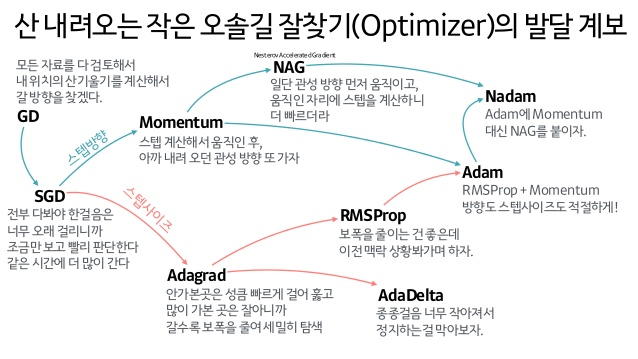


출처: https://sacko.tistory.com/42 [데이터 분석하는 문과생, 싸코]

In [31]:
def gen_flow_multi_inputs(I1, I2, y, batch_size):
    gen1 = ImageDataGenerator(horizontal_flip=True, # 인풋을 무작위로 가로로 뒤집음
                             vertical_flip=True, # 인풋을 무작위로 세로로 뒤집음
                             width_shift_range=0., # <1인 경우 전체 가로넓이에서의 비율
                             height_shift_range=0., # <1인 경우 전체 세로넓이에서의 비율, >=1인 경우 픽셀의 개수
                             channel_shift_range=0., # 무작위 채널 이동의 범위
                             zoom_range=0.2, # 무작위 줌의 범위, [1-0.2, 1+0.2]
                             rotation_range=10) # 무작위 회전의 각도 범위
    gen2 = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             width_shift_range=0.,
                             height_shift_range=0.,
                             channel_shift_range=0,
                             zoom_range=0.2,
                             rotation_range=10)
    genI1 = gen1.flow(I1, y, batch_size = batch_size, seed = 57, shuffle = False)
    genI2 = gen1.flow(I1, I2, batch_size = batch_size, seed = 57, shuffle = False)
    while True:
        I1i = genI1.next()
        I2i = genI2.next()
        # I1i[0].shape 출력
        np.testing.assert_array_equal(I2i[0], I1i[0])
        yield [I1i[0], I2i[1], I1i[1]]

## ImageDataGenerator
* 데이터 부풀리기
* 실시간 데이터 증강을 사용해서 텐서 이미지 데이터 배치를 생성. 데이터에 대해 (배치 단위로) 루프가 순환
* 관련 인수: https://keras.io/ko/preprocessing/image/

## flow
* ImageDataGenerator 디버깅
* Generator를 이용해서 학습하기 전, 먼저 변형된 이미지에 이상한 점이 없는지 확인해야 합니다. 케라스는 이를 돕기 위해 flow라는 함수를 제공합니다. 여기서 rescale 인자는 빼고 진행합니다—255배 어두운 이미지는 아무래도 눈으로 확인하기 힘들 테니까 말이죠.

출처: https://keraskorea.github.io/posts/2018-10-24-little_data_powerful_model/

## np.testing.assert_array_equal
* 두 array 객체가 같지 않으면 AssertionError 발생
* 두 개의 array_like 객체가 주어지면 모양이 같고 이러한 객체의 모든 요소가 동일한 지 확인


## 파이썬의 Generator 알아보기
while true 와 yield

https://winterj.me/Python-Generator/

In [32]:
def train_model(model, batch_size, epochs, checkpoint_name, X_train, y_train, val_data, verbose = 2):
    callbacks = [ModelCheckpoint(checkpoint_name, save_best_only = True, monitor = 'val_loss')]
    datagen = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=True,
                                   width_shift_range=0.,
                                   height_shift_range=0.,
                                   channel_shift_range=0,
                                   zoom_range=0.2,
                                   rotation_range=10)
    x_test, y_test = val_data
    try:
        model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size), epochs = epochs,
                                    steps_per_epoch=len(X_train) / batch_size,
                                    validation_data=(x_test, y_test), verbose = 1,
                                    callbacks=callbacks)
    except KeyboardInterrupt:
        if verbose > 0:
            print('Interrupted')
    if verbose > 0:
        print('Loading model')
    model.load_weights(filepath=checkpoint_name)
    return model


## ModelCheckpoint 
* 콜백 함수는 Keras에서 모델을 학습할 때마다 중간중간에 콜백 형태로 알려줌
* ModelCheckpoint의 속성으로 verbose는 해당 함수의 진행 사항의 출력 여부, save_best_only는 모델의 정확도가 최고값을 갱신했을 때만 저장하도록 하는 옵션입니다.

In [34]:
# 모델 학습
def gen_model_weights(lr, decay, channels, relu, batch_size, epochs, path_name, data, verbose = 2):
    X_train, y_train, X_test, y_test, X_val, y_val = data
    model, parial_model = get_model_notebook(lr, decay, channels, relu)
    model = train_model(model, batch_size, epochs, path_name, X_train, y_train, (X_test, y_test), verbose = verbose)
    
    if verbose > 0:
        loss_val, acc_val = model.evaluate(X_val, y_val,
                                          verbose = 0, batch_size = batch_size)
        
        loss_train, acc_train = model.evaluate(X_test, y_test,
                                              verbose = 0, batch_size = batch_size)
        
        print('Val/Train Loss:', str(loss_val) + '/' + str(loss_train), \
             'Val/Train Acc:', str(acc_val) + '/' + str(acc_train))
    return model, partial_model

In [35]:
# train all 3 models
def train_models(dataset, lr, batch_size, max_epoch, verbose = 2, return_model = False):
    y_train, X_b, X_images = dataset
    y_train_full, y_val, X_b_full, X_b_val, X_images_full, X_images_val = train_test_split(y_train, X_b, X_images, random_state = 687, train_size = 0.9)
    
    y_train, y_test, X_b_train, X_b_test, X_images_train, X_images_test = train_test_split(y_train_full, X_b_full, X_images_full, random_state = 576, train_size = 0.85)
    
    if train_b:
        if verbose > 0:
            print('Training bandwidth network')
        data_b1 = (X_b_train, y_train, X_b_test, y_test, X_b_val, y_val)
        model_b, model_b_cut = gen_model_weights(lr, 1e-6, 3, 'relu', batch_size, max_epoch, 'model_b', data = data_b1, verbose = verbose)
        
    if train_img:
        if verbose > 0:
            print('Training image network')
        data_images = (X_images_train, y_train, X_images_test, y_test, X_images_val, y_val)
        model_images, model_images_cut = gen_model_weights(lr, 1e-6, 3, 'relu', batch_size, max_epoch, 'model_img', data_images, verbose = verbose)
        
    if train_total:
        common_model = combined_model(model_b_cut, model_images_cut, lr/2, 1e-7)
        common_x_train = [X_b_full, X_images_full]
        common_y_train = y_train_full
        common_x_val = [X_b_val, X_images_val]
        common_y_val = y_val
        if verbose > 0:
            print('Training common network')
        callbacks = [ModelCheckpoint('common', save_best_only=True, monitor = 'val_loss')]
        try:
            common_model.fit_generator(gen_flow_multi_inputs(X_b_full, X_images_full, y_train_full, batch_size), epochs = 30,
                                      steps_per_epoch = len(X_b_full)/batch_size, validation_data = (common_x_val, common_y_val),
                                      verbose = 1, callbacks = callbacks)
        except KeyboardInterrupt:
            pass
        common_model.load_weights(filepath = 'common')
        loss_val, acc_val = common_model.evaluate(common_x_val, common_y_val, verbose = 0, batch_size = batch_size)
        loss_train, acc_train = common_model.evaluate(common_x_train, common_y_train, verbose = 0, batch_size = batch_size)
        
        if verbose > 0:
            print('Loss:', loss_val, 'Acc: ', acc_val)
    if return_model:
        return common_model
    else:
        return (loss_train, acc_train), (loss_val, acc_val)

훈련에 사용되는 모델 매개 변수는 모든 데이터를 처리하기에 충분한 계산 능력이 있다고 가정합니다.

(명백한 지 아닌지는 모르겠 음) 여기서 중요한 순간은 3 세트를 저장하는 것입니다. 검증 세트를 기반으로 모델을 선택하면 검증 세트에 대한 무관한 관찰을 유발하고 최종 평가 점수에 영향을 미치기 때문에 최종 성능에 영향을 미치기 때문입니다. 

In [36]:
# best parameters 
# epochs:250
# learning rate: 8e-5
# batch size: 32
common_model = train_models((y_train, X_b, X_images), 7e-04, 32, 50, 1, return_model =True)

Training bandwidth network
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
39/38 [==============================] - ETA: 0s - loss: 0.6550 - accuracy: 0.5987WARNING:tensorflow:From c:\users\dldud\anaconda3\envs\ai_env\lib\site-packages\tensorflow\python\training\tracking\tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model_b\assets
39/38 [==============================] - 16s 410ms/step - loss: 0.6550 - accuracy: 0.5987 - val_loss: 1.8610 - val_accuracy: 0.5253
Epoch 2/50
39/38 [==============================] - 15s 390ms/step - loss: 0.6166 - accuracy: 0.6183 - val_loss: 1.4466 - val_accuracy

39/38 [==============================] - 8s 216ms/step - loss: 0.3115 - accuracy: 0.8597 - val_loss: 0.3114 - val_accuracy: 0.8618
Epoch 41/50
39/38 [==============================] - 8s 213ms/step - loss: 0.2949 - accuracy: 0.8728 - val_loss: 0.3287 - val_accuracy: 0.8756
Epoch 42/50
39/38 [==============================] - 8s 209ms/step - loss: 0.2998 - accuracy: 0.8646 - val_loss: 0.3275 - val_accuracy: 0.8802
Epoch 43/50
39/38 [==============================] - 8s 214ms/step - loss: 0.2801 - accuracy: 0.8736 - val_loss: 0.3360 - val_accuracy: 0.8756
Epoch 44/50
39/38 [==============================] - 9s 235ms/step - loss: 0.3028 - accuracy: 0.8736 - val_loss: 0.3551 - val_accuracy: 0.8341
Epoch 45/50
39/38 [==============================] - 9s 240ms/step - loss: 0.2956 - accuracy: 0.8679 - val_loss: 0.3660 - val_accuracy: 0.8571
Epoch 46/50
39/38 [==============================] - 8s 210ms/step - loss: 0.2656 - accuracy: 0.8785 - val_loss: 0.4674 - val_accuracy: 0.8433
Epoch 47/50

OpError: 

In [ ]:
if predict_submission:
    print('Reading test dataset')
    test = pd.read_json('input/test.json/data/processed/test.json')
    y_fin, X_fin_b, X_fin_img = create_dataset(test, False)
    print('Predicting')
    prediction = common_model.predict([X_fin_b, X_fin_img], verbose = 1, batch_size = 32)
    print('Submitting')
    submission = pd.DataFrame({'id': test['id'], 'is_iceberg': prediction.reshape((prediction.shape[0]))})
    
    submission.to_csv('./submission.csv', index = False)
    print('Done')

## TODO:
* https://www.kaggle.com/muonneutrino/exploration-transforming-images-in-python에서 기능 추가
* 기본 모델을 수정하고 사진 및 대역폭에 대해 다양한 모델을 학습
* 보다 의미있는 노이즈 제거 알고리즘 선택
* 컨벌루션 네트의 출력 기능에 XBG 사용
* 추가 기능을 추출하고 데이터를 정리하기 위해 학습 및 테스트 데이터에서 노이즈 제거 오토 인코더 학습
* 데이터 전처리 병렬화